In [1]:
path = './'
import sys
sys.path.append(path)

### Choose GPU settings, import libraries

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras import Input
from tensorflow.keras import Model
import tensorflow.keras.backend as K

#from tensorflow.keras import mixed_precision

In [3]:
#print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Restricting Memory")
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Restricting Memory


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
import importlib
importlib.reload(keras_helper)
from keras_helper import *
from skimage.transform import resize
from clr_callback import CyclicLR
import math as m

### Some training parameters

In [5]:
h,w=64,64
nepochs=60
wt_path = 'wts4' #Where to store network weights
batch_size = 32
Init_lr = 1e-2

nconv = 32

if (not os.path.isdir(path+wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [6]:
# !wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
# !wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true

In [7]:
data_diffr = np.load('20191008_39_diff.npz')['arr_0']

In [8]:
#plt.matshow(np.log10(data_diffr[0,0]))
try:
    data_diffr_red = np.load(path + '../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


<ipython-input-8-7c74569366e7>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_diffr.shape[0])):


  0%|          | 0/161 [00:00<?, ?it/s]

In [10]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load('20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


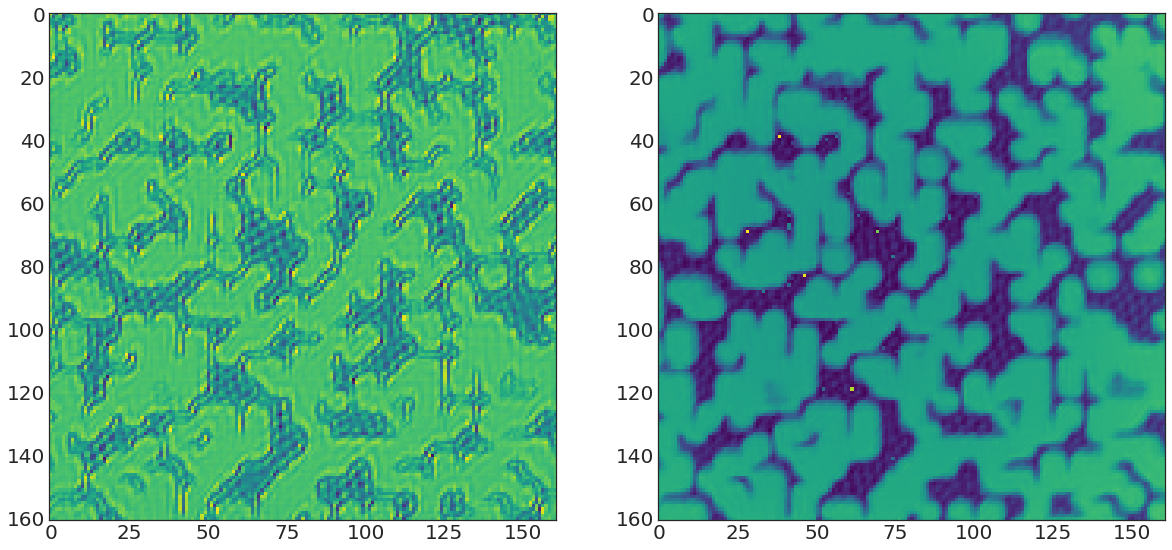

In [11]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [12]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

(16100, 64, 64, 1) (3600, 64, 64, 1)


### Save the test data for later use

In [14]:
#np.save('data/X_test.npy', X_test) #Diffraction data
#np.save('data/Y_I_test.npy', Y_I_test) #Intensity data
#np.save('data/Y_phi_test.npy', Y_phi_test) #Intensity data

## Define the network structure

In [15]:
class pool_module(Layer):
    def __init__(self, nfilters,use_stride=True, w1=3,w2=3,p1=2,p2=2,padding='same',data_format='channels_last'):
        super(pool_module, self).__init__()
        # conv layer
        self.use_stride = use_stride
        self.conv1 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)
        self.conv2 = Conv2D(nfilters, (w1, w2), strides=(p1, p2), activation='relu', padding=padding, data_format=data_format)
        self.maxpool = MaxPool2D((p1, p2), padding=padding, data_format=data_format)
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        if self.use_stride:
            x = self.conv2(x)
        else:
            x = self.conv1(x)
            x = self.maxpool(x)
        return x
                            

class up_module(Layer):
    def __init__(self, nfilters,use_stride=True, w1=3,w2=3,p1=2,p2=2,padding='same',data_format='channels_last'):
        super(up_module, self).__init__()
        self.use_stride = use_stride
        # conv layer
        self.conv1 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)
        self.conv2 = Conv2DTranspose(nfilters, (w1, w2), strides=(p1, p2), activation='relu', padding=padding, data_format=data_format)
        self.upsample = UpSampling2D((p1, p2), data_format=data_format)
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        if self.use_stride:
            x = self.conv2(x)
        else:
            x = self.conv1(x)
            x = self.upsample(x)
        return x

In [16]:
class ReconModel(Model):
    def __init__(self, n_filters: int = 32):
        super(ReconModel, self).__init__()

        self.pool_module1 = pool_module(nfilters = 1*n_filters)
        self.pool_module2 = pool_module(nfilters = 2*n_filters)
        self.pool_module3 = pool_module(nfilters = 4*n_filters)
        
        self.up_module1A = up_module(nfilters = 4*n_filters)
        self.up_module2A = up_module(nfilters = 2*n_filters)
        self.up_module3A = up_module(nfilters = 1*n_filters)
        self.convA = Conv2D(1, (3, 3), padding='same')
        self.sigmoid = sigmoid
        
        self.up_module1B = up_module(nfilters = 4*n_filters)
        self.up_module2B = up_module(nfilters = 2*n_filters)
        self.up_module3B = up_module(nfilters = 1*n_filters)
        self.convB = Conv2D(1, (3, 3), padding='same')
        self.tanh = tanh
    
    def call(self, inputs):
        x0 = self.pool_module1(inputs)
        x0 = self.pool_module2(x0)
        encoded = self.pool_module3(x0)

        x1 = self.up_module1A(encoded)
        x1 = self.up_module2A(x1)
        x1 = self.up_module3A(x1)
        x1 = self.convA(x1)
        decoded1 = self.sigmoid(x1)       
        
        x2 = self.up_module1B(encoded)
        x2 = self.up_module2B(x2)
        x2 = self.up_module3B(x2)
        x2 = self.convB(x2)
        decoded2 = m.pi * self.tanh(x2)
                
        return [decoded1, decoded2]

In [17]:
tf.keras.backend.clear_session()
np.random.seed(123)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

#model
autoencoder = ReconModel(n_filters=nconv)
autoencoder.build(input_shape=(None, h, w, 1))
autoencoder.call(Input(shape=(h, w, 1)))
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "recon_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pool_module (pool_module)    (None, 32, 32, 32)        9568      
_________________________________________________________________
pool_module_1 (pool_module)  (None, 16, 16, 64)        55424     
_________________________________________________________________
pool_module_2 (pool_module)  (None, 8, 8, 128)         221440    
_________________________________________________________________
up_module (up_module)        (None, 16, 16, 128)       295168    
_________________________________________________________________
up_module_1 (up_module)      (None, 32, 32, 64)        110720    
_________________________________________________________________
up_module_2 (up_module)      (None, 64, 64, 32)        27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 1)         

In [18]:
# min_lr = 1e-4
# top_lr = Init_lr
# train_size = len(X_train)
# step_size = int(train_size / batch_size) * 8
# gamma = 10**(np.log10(min_lr / top_lr) /
#              (train_size / batch_size * nepochs))
# reduce_lr = CyclicLR(base_lr=min_lr,
#                      max_lr=top_lr,
#                      step_size=step_size,
#                      mode='exp_range',
#                      gamma=gamma)
        
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

In [19]:
checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=True, mode='auto', period=1)

history=autoencoder.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Epoch 1/60
478/478 [==============================] - 56s 15ms/step - loss: 0.7400 - output_1_loss: 0.0947 - output_2_loss: 0.6453 - val_loss: 0.4852 - val_output_1_loss: 0.0202 - val_output_2_loss: 0.4649

Epoch 00001: val_loss improved from inf to 0.48517, saving model to wts4/weights.01.hdf5
Epoch 2/60
478/478 [==============================] - 7s 15ms/step - loss: 0.4418 - output_1_loss: 0.0110 - output_2_loss: 0.4308 - val_loss: 0.3509 - val_output_1_loss: 0.0073 - val_output_2_loss: 0.3436

Epoch 00002: val_loss improved from 0.48517 to 0.35087, saving model to wts4/weights.02.hdf5
Epoch 3/60
478/478 [==============================] - 7s 14ms/step - loss: 0.3413 - output_1_loss: 0.0069 - output_2_loss: 0.3344 - val_loss: 0.3165 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.3101

Epoch 00003: val_loss improved from 0.35087 to 0.31654, saving model to wts4/weights.03.hdf5
Epoch 4/60
478/478 [==============================] - 6s 12ms/step - loss: 0.3032 - output_1_loss: 0.0066 

Epoch 29/60
478/478 [==============================] - 5s 11ms/step - loss: 0.1483 - output_1_loss: 0.0052 - output_2_loss: 0.1431 - val_loss: 0.1706 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.1653

Epoch 00029: val_loss improved from 0.17282 to 0.17064, saving model to wts4/weights.29.hdf5
Epoch 30/60
478/478 [==============================] - 5s 11ms/step - loss: 0.1479 - output_1_loss: 0.0051 - output_2_loss: 0.1428 - val_loss: 0.1693 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.1640

Epoch 00030: val_loss improved from 0.17064 to 0.16930, saving model to wts4/weights.30.hdf5
Epoch 31/60
478/478 [==============================] - 5s 11ms/step - loss: 0.1469 - output_1_loss: 0.0051 - output_2_loss: 0.1417 - val_loss: 0.1742 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.1690

Epoch 00031: val_loss did not improve from 0.16930
Epoch 32/60
478/478 [==============================] - 5s 10ms/step - loss: 0.1451 - output_1_loss: 0.0051 - output_2_loss: 0.1400 - val_loss:

478/478 [==============================] - 5s 11ms/step - loss: 0.0897 - output_1_loss: 0.0041 - output_2_loss: 0.0855 - val_loss: 0.1401 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.1352

Epoch 00057: val_loss did not improve from 0.13991
Epoch 58/60
478/478 [==============================] - 5s 10ms/step - loss: 0.0893 - output_1_loss: 0.0041 - output_2_loss: 0.0852 - val_loss: 0.1401 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.1352

Epoch 00058: val_loss did not improve from 0.13991
Epoch 59/60
478/478 [==============================] - 5s 11ms/step - loss: 0.0889 - output_1_loss: 0.0041 - output_2_loss: 0.0848 - val_loss: 0.1401 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.1352

Epoch 00059: val_loss did not improve from 0.13991
Epoch 60/60
478/478 [==============================] - 4s 9ms/step - loss: 0.0888 - output_1_loss: 0.0041 - output_2_loss: 0.0847 - val_loss: 0.1402 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.1353

Epoch 00060: val_loss did not im

## Plot metrics of the training

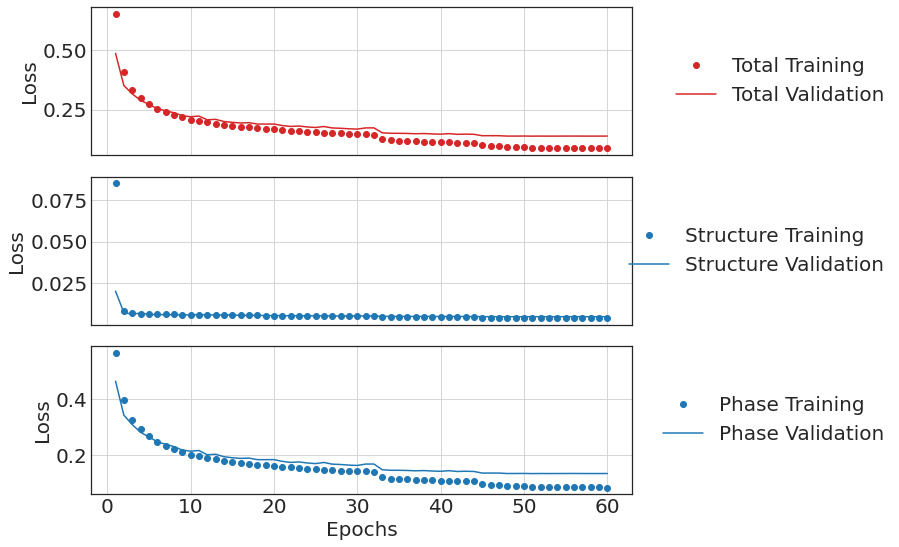

In [20]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['output_1_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_output_1_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['output_2_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_output_2_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [21]:
np.save(path+'str_history', history.history)

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [22]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save(path+'%s/min_epoch' %(wt_path), min_epoch)

51


### Make prediction using the diffraction data alone

In [23]:
preds_intens=(autoencoder.predict(X_test))
print (preds_intens[0].shape)

(3600, 64, 64, 1)


<Figure size 432x288 with 0 Axes>

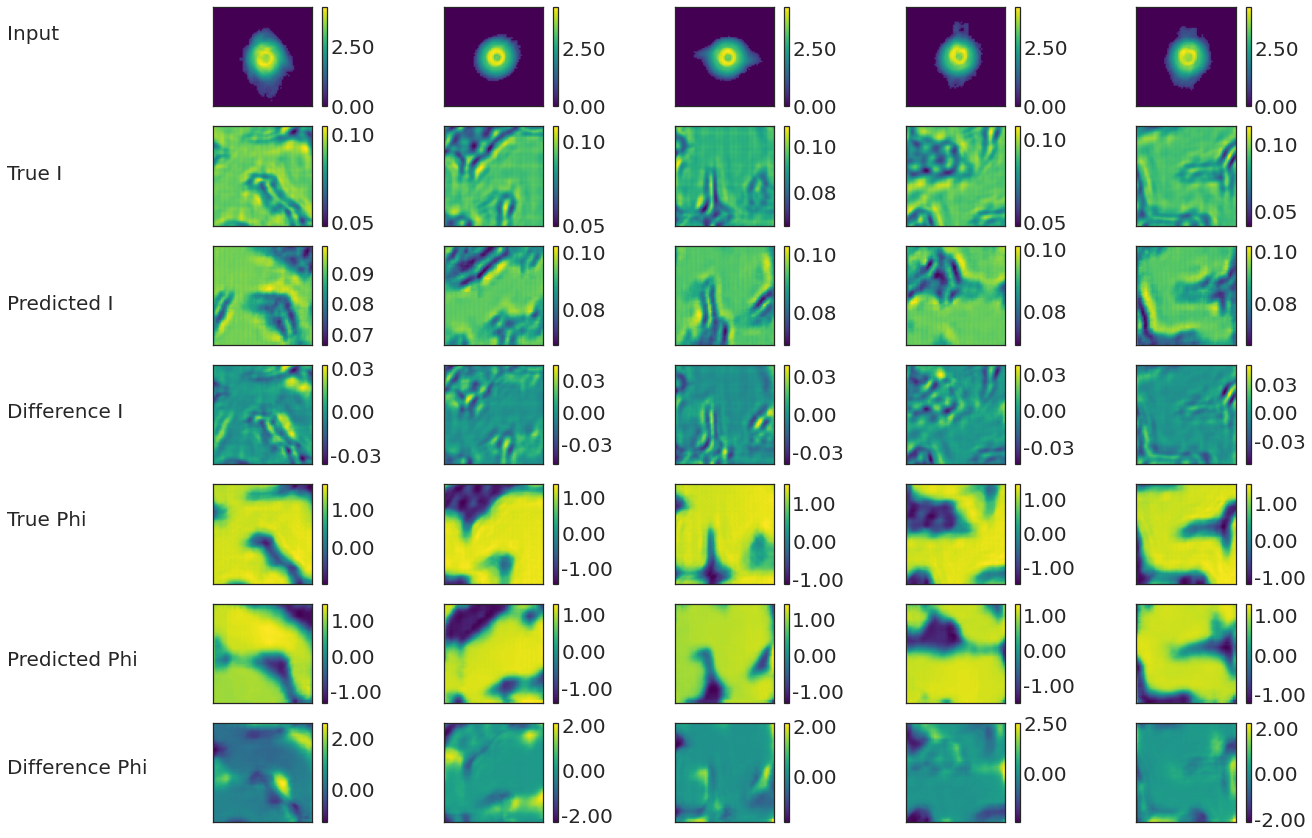

In [24]:
h,w = 64,64
ntest=preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()